# 决策树

In [5]:
import numpy as np
from collections import Counter

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        # 特征索引
        self.feature = feature
        # 特征阈值
        self.threshold = threshold
        # 左子树
        self.left = left
        # 右子树
        self.right = right
        # 叶节点值
        self.value = value

class DecisionTree:
    def __init__(self, max_depth=10, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None
        
    def fit(self, X, y):
        """训练决策树"""
        self.n_classes = len(np.unique(y))
        self.root = self._grow_tree(X, y)
        
    def _grow_tree(self, X, y, depth=0):
        """递归构建决策树"""
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))
        
        # 检查停止条件
        if (self.max_depth is not None and depth >= self.max_depth) or \
           n_samples < self.min_samples_split or \
           n_labels == 1:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)
        
        # 寻找最佳分割点
        feature_idxs = np.arange(n_features)
        best_feature, best_threshold = self._best_split(X, y, feature_idxs)
        
        # 创建子节点
        left_idxs = X[:, best_feature] <= best_threshold
        right_idxs = X[:, best_feature] > best_threshold
        left = self._grow_tree(X[left_idxs], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs], y[right_idxs], depth + 1)
        
        return Node(best_feature, best_threshold, left, right)
    
    def _best_split(self, X, y, feature_idxs):
        """寻找最佳分割特征和阈值"""
        best_gain = -1
        split_feature, split_threshold = None, None
        
        for feature_idx in feature_idxs:
            X_column = X[:, feature_idx]
            thresholds = np.unique(X_column)
            
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)
                
                if gain > best_gain:
                    best_gain = gain
                    split_feature = feature_idx
                    split_threshold = threshold
                    
        return split_feature, split_threshold
    
    def _information_gain(self, y, X_column, threshold):
        """计算信息增益"""
        parent_entropy = self._entropy(y)
        
        # 生成左右子树
        left_idxs = X_column <= threshold
        right_idxs = X_column > threshold
        
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        
        # 计算加权平均熵
        n = len(y)
        n_l, n_r = len(y[left_idxs]), len(y[right_idxs])
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r
        
        return parent_entropy - child_entropy
    
    def _entropy(self, y):
        """计算熵"""
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log(p) for p in ps if p > 0])
    
    def _most_common_label(self, y):
        """返回最常见的标签"""
        counter = Counter(y)
        return counter.most_common(1)[0][0]
    
    def predict(self, X):
        """预测样本的类别"""
        return np.array([self._traverse_tree(x, self.root) for x in X])
    
    def _traverse_tree(self, x, node):
        """遍历决策树进行预测"""
        if node.value is not None:
            return node.value
        
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

# 生成示例数据
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# 生成分类数据
X, y = make_classification(
    n_samples=1000, 
    n_features=10,
    n_classes=2,
    random_state=42
)

print(X.shape, y.shape)

# 分割训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 创建和训练决策树
tree = DecisionTree(max_depth=5)
tree.fit(X_train, y_train)

# 预测
predictions = tree.predict(X_test)

# 计算准确率
accuracy = np.mean(predictions == y_test)
print(f"Accuracy: {accuracy:.4f}")



(1000, 10) (1000,)
Accuracy: 0.8750


In [10]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'max_depth': 5,
    'eta': 0.3,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'  # Changed from 'logliss' to 'logloss'
}

num_rounds =100

# 设置早停机制
early_stopping_rounds = 10
evals = [(dtrain, 'train'), (dtest, 'eval')]

model = xgb.train(
    params,
    dtrain,
    num_rounds,
    evals=evals,
    early_stopping_rounds=early_stopping_rounds,
    verbose_eval=10  # 每10轮打印一次评估结果
)

predictions = model.predict(dtest)

pred_labels = [1 if p>0.5 else 0 for p in predictions]
accuracy = accuracy_score(y_test, pred_labels)
print(f"\nAccuracy: {accuracy:.4f}")


[0]	train-logloss:0.49320	eval-logloss:0.52746
[10]	train-logloss:0.10547	eval-logloss:0.27328
[20]	train-logloss:0.06254	eval-logloss:0.28072
[23]	train-logloss:0.05378	eval-logloss:0.28541

Accuracy: 0.8850


统计方法检测到 20 个异常
机器学习方法检测到 50 个异常


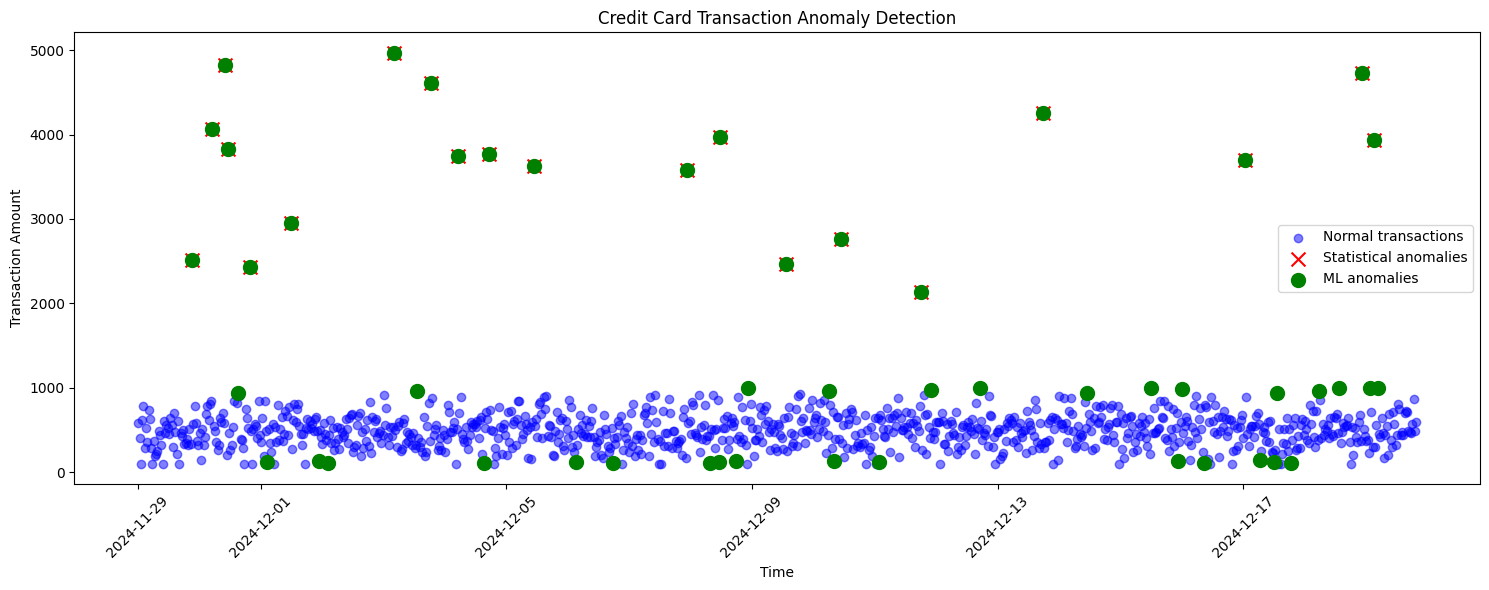

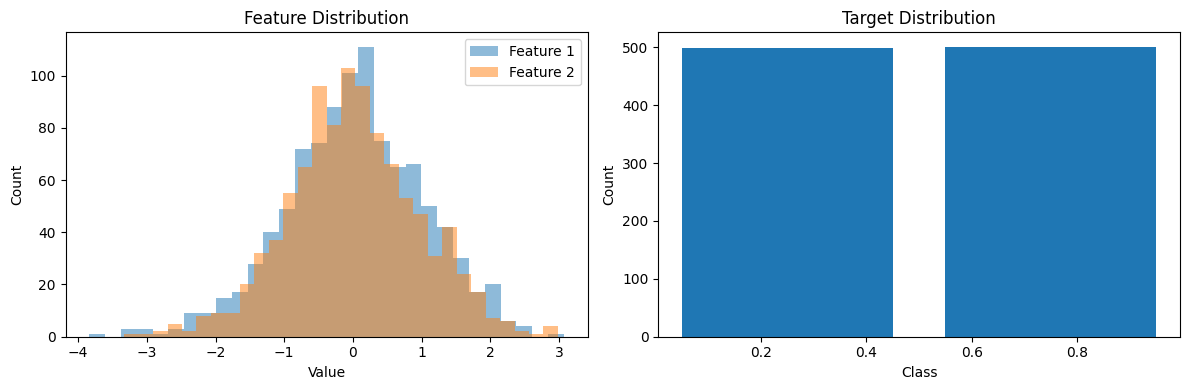

/Users/haoyiwen/Documents/ai/2022-Machine-Learning-Specializatio/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5112 - loss: 0.7369 - val_accuracy: 0.6650 - val_loss: 0.6193
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6437 - loss: 0.6303 - val_accuracy: 0.7700 - val_loss: 0.5339
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7313 - loss: 0.5405 - val_accuracy: 0.8450 - val_loss: 0.4523
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8345 - loss: 0.4321 - val_accuracy: 0.8750 - val_loss: 0.3748
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8697 - loss: 0.3596 - val_accuracy: 0.9000 - val_loss: 0.3020
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8711 - loss: 0.3084 - val_accuracy: 0.9150 - val_loss: 0.2433
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9273 - loss: 0.2542 - val_accuracy: 0.9450 - val_loss: 0.2012
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9426 - loss: 0.1894 - val_accuracy: 0.9450 - v

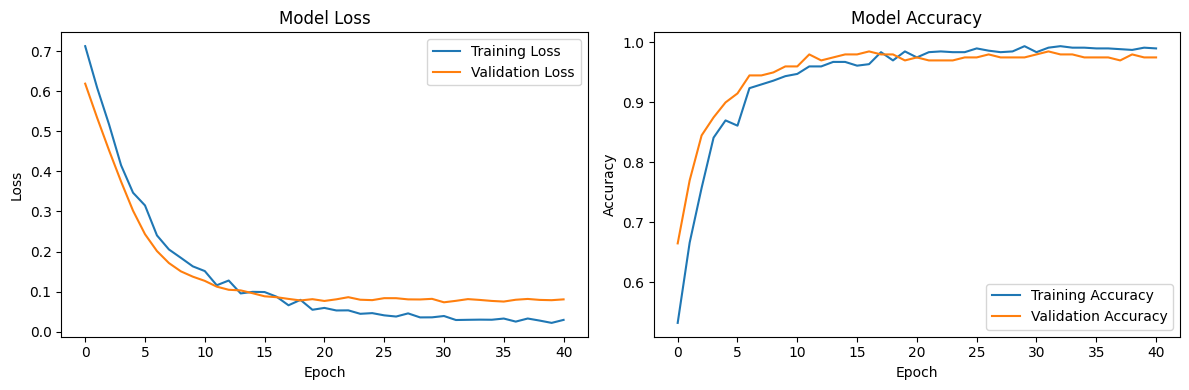


Final Results:
Training Accuracy: 1.0000
Validation Accuracy: 0.9800
